Using the data from the audio analysis that Spotify perform to each song we want to build some visualizations to understand the proximities of the songs.

First we are going to perform a PCA to plot the first two and the first three componentes.

Then we will cluster the data using K-means algorithm and visualize the results.

In [160]:
import os
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
path_scritps = os.getcwd()
path_data = path_scritps.replace("Scripts", "Data")

In [3]:
os.listdir(path_data)

['consolidate_raw_2021-09-19.csv',
 'consolidate_raw_2021_37.csv',
 'consolidate_raw_audio_features_2021-09-19.csv',
 'consolidate_raw_audio_features_2021_37.csv',
 'consolidate_raw_audio_features_2021_37.tex',
 'novedades_viernes_2021-09-19.csv',
 'novedades_viernes_2021_33.csv',
 'novedades_viernes_2021_34.csv',
 'novedades_viernes_2021_36.csv',
 'novedades_viernes_2021_37.csv',
 'popeton_2021-09-19.csv',
 'popeton_2021_33.csv',
 'popeton_2021_34.csv',
 'popeton_2021_36.csv',
 'popeton_2021_37.csv',
 'songs',
 'top_colombia_2021-09-19.csv',
 'top_colombia_2021_33.csv',
 'top_colombia_2021_34.csv',
 'top_colombia_2021_36.csv',
 'top_colombia_2021_37.csv',
 'viral_2021-09-19.csv',
 'viral_2021_33.csv',
 'viral_2021_34.csv',
 'viral_2021_36.csv',
 'viral_2021_37.csv']

In [4]:
# Load the most recent file
data = pd.read_csv(path_data + "/consolidate_raw_audio_features_" + 
    "2021-09-19" + ".csv", sep = ";", index_col = 0)

In [5]:
# Remove duplicate songs
data = data.sort_values("top50").drop_duplicates("song_id").reset_index(drop = True)

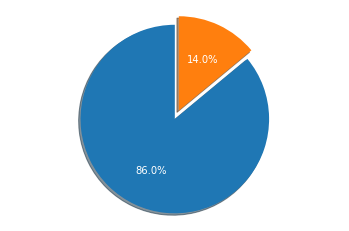

In [26]:
# Pie chart of the output
labels = 'No éxito', 'Éxito'
sizes = data["top50"].value_counts()/data["top50"].size
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Éxito')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels = labels, autopct = '%1.1f%%',
        shadow = True, startangle = 90, textprops={'color':"w"})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(r"C:\Users\User\Downloads\marca.png", transparent = True, dpi = 1200)
plt.show()

In [149]:
# Create a Polar plot of two songs

# Select only numeric variables
df = data.select_dtypes(include = np.number)
# We are going to scale all the variables to be between 0 and 1
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
# We select two songs arbitrarily
song_names = ["200 COPAS", "Yonaguni"]
mask = data.song.isin(song_names)
columns_to_drop = ["position", "popularity", "time_signature", "speechiness", 
    "instrumentalness", "acousticness", "liveness"]
polar_df = df_scaled.loc[mask,].drop(columns = columns_to_drop) \
    .assign(Name = ["200 Copas", "Yonaguni"]) \
        .melt(id_vars = ["Name"])
polar_df # Pepas, Yonaguni duration 0.59, 0.38

,Name,variable,value
0,200 Copas,duration,0.414938
1,Yonaguni,duration,0.387540
2,200 Copas,danceability,0.431944
3,Yonaguni,danceability,0.611111
4,200 Copas,energy,0.685597
5,Yonaguni,energy,0.623602
6,200 Copas,key,0.818182
7,Yonaguni,key,0.090909
8,200 Copas,loudness,0.743749
9,Yonaguni,loudness,0.778872


In [112]:
fig = px.line_polar(polar_df, r = 'value', theta = 'variable', 
    line_close = True, color = "Name")
fig.update_traces(fill = 'toself')
fig.show()

In [150]:
df_scaled = df_scaled.drop(columns = ["position", "popularity", "time_signature", "mode"])

In [156]:
# Perform PCA
pca = PCA(n_components = 3)  
pc = pca.fit_transform(df_scaled)

names = ["Principal Component " + str(i) for i in range(1, 4)]
pc = pd.DataFrame(pc, columns = names)
pc = pd.concat([pc, data], axis = 1)
pc = pc.rename(columns = {"top50": "Éxito"})

In [157]:
fig = px.scatter(pc, x = "Principal Component 1", y = "Principal Component 2", 
    hover_data = ["song", "Éxito"], color = "Éxito")
fig.update_yaxes(range = [-1, 1])
fig.update_xaxes(range = [-1, 1])
fig.show()

In [154]:
fig = px.scatter_3d(pc, x = "Principal Component 1", y = "Principal Component 2", 
    z = "Principal Component 3", hover_data = ["song", "top50"], color = "top50")
fig.update_scenes(aspectratio = dict(x=1, y=1, z=1))

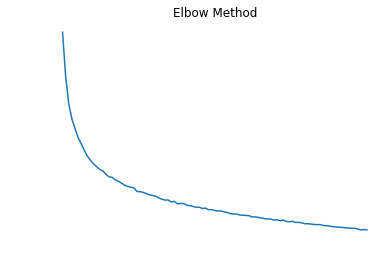

In [162]:
# Perform K-Means
wcss = []
X = df_scaled.values
for i in range(1, 100):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, 
        n_init = 10, random_state = 666)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()